# Info Dataset

Cada linha representa um foco de queimada, com atributos como:

DataHora – data e hora da detecção (UTC)

Satelite – satélite/algoritmo responsável pela detecção (no caso o satélite aqua)

Pais, Estado, Municipio – localização administrativa

Bioma – bioma onde o foco ocorre

DiaSemChuva – número de dias sem chuva

Precipitacao – chuva acumulada no dia (mm)

RiscoFogo – índice de risco de fogo (0–1)

Latitude, Longitude – coordenadas geográficas em graus decimais

FRP – potência radiativa do fogo (MW)

In [8]:
# ==========================================
# 1. Importação de bibliotecas
# ==========================================
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans, DBSCAN
from sklearn.decomposition import PCA
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import silhouette_score
import networkx as nx

sns.set(style="whitegrid", palette="deep")


# Leitura dos Arquivos

In [9]:

data_dir = Path("bdqueimadas_aqua")

dfs = []
cols_ref = None

for csv_path in data_dir.glob("*.csv"):
    print(f"Lendo {csv_path.name}...")
    
    df_tmp = pd.read_csv(csv_path, sep=',', low_memory=False)
    
    # opcional: garantir que todas as colunas são iguais
    if cols_ref is None:
        cols_ref = list(df_tmp.columns)
    else:
        if list(df_tmp.columns) != cols_ref:
            raise ValueError(f"Colunas diferentes em: {csv_path.name}")
    
    dfs.append(df_tmp)

# concatena todos, como se fosse "um embaixo do outro"
df = pd.concat(dfs, ignore_index=True)

print("Total de linhas após concatenação:", len(df))
print("Colunas:", df.columns.tolist())
df.head()

Lendo bdqueimadas_2017-11-25_2018-11-24.csv...
Lendo bdqueimadas_2021-11-25_2022-11-24.csv...
Lendo bdqueimadas_2016-11-25_2017-11-24.csv...
Lendo bdqueimadas_2023-11-25_2024-11-24.csv...
Lendo bdqueimadas_2022-11-25_2023-11-24.csv...
Lendo bdqueimadas_2019-11-25_2020-11-24.csv...
Lendo bdqueimadas_2018-11-25_2019-11-24.csv...
Lendo bdqueimadas_2015-11-25_2016-11-24.csv...
Lendo bdqueimadas_2024-11-25_2025-11-25.csv...
Lendo bdqueimadas_2020-11-25_2021-11-24.csv...
Total de linhas após concatenação: 1943539
Colunas: ['DataHora', 'Satelite', 'Pais', 'Estado', 'Municipio', 'Bioma', 'DiaSemChuva', 'Precipitacao', 'RiscoFogo', 'FRP', 'Latitude', 'Longitude']


,DataHora,Satelite,Pais,Estado,Municipio,Bioma,DiaSemChuva,Precipitacao,RiscoFogo,FRP,Latitude,Longitude
0,2017/11/25 15:56:00,AQUA_M-T,Brasil,BAHIA,MANSIDÃO,Cerrado,0.0,0.0,1.0,100.0,-11.170,-44.173
1,2017/11/25 15:56:00,AQUA_M-T,Brasil,BAHIA,MANSIDÃO,Cerrado,0.0,0.0,1.0,123.8,-11.169,-44.169
2,2017/11/25 15:56:00,AQUA_M-T,Brasil,BAHIA,MANSIDÃO,Cerrado,0.0,0.0,1.0,42.1,-10.750,-44.113
3,2017/11/25 15:56:00,AQUA_M-T,Brasil,BAHIA,MANSIDÃO,Cerrado,0.0,0.0,1.0,136.2,-11.165,-44.131
4,2017/11/25 15:56:00,AQUA_M-T,Brasil,BAHIA,MANSIDÃO,Cerrado,0.0,0.0,1.0,123.2,-11.165,-44.127


# Pré-processamento

In [10]:
import unicodedata
import pandas as pd

def normalizar_texto(s):
    if pd.isna(s):
        return s
    s = str(s).strip().upper()
    s = unicodedata.normalize("NFKD", s)
    s = "".join(ch for ch in s if not unicodedata.combining(ch))
    return s

# sobrescreve as colunas originais
for col in ["Estado", "Municipio", "Bioma"]:
    df[col] = df[col].apply(normalizar_texto)

In [11]:
# Converter DataHora para datetime
df["DataHora"] = pd.to_datetime(df["DataHora"], errors="coerce")

# Criar ano e mês (útil para agregação por período)
df["ano"] = df["DataHora"].dt.year
df["mes"] = df["DataHora"].dt.month

# Só para conferir
df[["DataHora", "ano", "mes"]].head()


,DataHora,ano,mes
0,2017-11-25 15:56:00,2017,11
1,2017-11-25 15:56:00,2017,11
2,2017-11-25 15:56:00,2017,11
3,2017-11-25 15:56:00,2017,11
4,2017-11-25 15:56:00,2017,11


In [12]:
# valores -999 (ou qualquer negativo) não fazem sentido -> NaN
df.loc[df["DiaSemChuva"] < 0, "DiaSemChuva"] = np.nan
df.loc[df["RiscoFogo"]   < 0, "RiscoFogo"]   = np.nan

In [13]:
df[["DiaSemChuva", "Precipitacao", "RiscoFogo"]].describe()


,DiaSemChuva,Precipitacao,RiscoFogo
count,1.920488e+06,1.940664e+06,1.929322e+06
mean,2.006981e+01,7.091513e-01,7.271708e-01
std,3.206446e+01,3.193083e+00,3.585901e-01
min,0.000000e+00,0.000000e+00,0.000000e+00
25%,2.000000e+00,0.000000e+00,4.500000e-01
50%,6.000000e+00,0.000000e+00,9.900000e-01
75%,2.200000e+01,0.000000e+00,1.000000e+00
max,8.270000e+02,1.430000e+02,1.000000e+00


In [14]:
# Exemplo: focar só no bioma Amazônia
# df = df[df["Bioma"] == "Amazônia"]

# Exemplo: focar só em um estado
# df = df[df["Estado"] == "MATO GROSSO"]


# Agrupando Dados

In [15]:
# Colunas de agrupamento (podem ser ajustadas)
group_cols = ["Estado", "Municipio", "Bioma", "ano", "mes"]

# Converter colunas numéricas (caso venham como string)
num_cols_raw = ["DiaSemChuva", "Precipitacao", "RiscoFogo", "FRP", "Latitude", "Longitude"]
for c in num_cols_raw:
    df[c] = pd.to_numeric(df[c], errors="coerce")

# Agregações: você pode mudar/ajustar
df_grp = (
    df
    .groupby(group_cols)
    .agg(
        num_focos=("FRP", "count"),
        frp_medio=("FRP", "mean"),
        dias_sem_chuva_medio=("DiaSemChuva", "mean"),
        precipitacao_media=("Precipitacao", "mean"),
        risco_fogo_medio=("RiscoFogo", "mean")
    )
    .reset_index()
)

df_grp.head()


,Estado,Municipio,Bioma,ano,mes,num_focos,frp_medio,dias_sem_chuva_medio,precipitacao_media,risco_fogo_medio
0,ACRE,ACRELANDIA,AMAZONIA,2016,6,4,23.900000,10.500000,0.000000,0.925000
1,ACRE,ACRELANDIA,AMAZONIA,2016,7,24,53.762500,19.208333,0.000000,1.000000
2,ACRE,ACRELANDIA,AMAZONIA,2016,8,66,76.672727,9.030303,0.445455,0.784848
3,ACRE,ACRELANDIA,AMAZONIA,2016,9,90,63.167778,4.177778,0.326667,0.666667
4,ACRE,ACRELANDIA,AMAZONIA,2016,10,4,17.125000,0.750000,3.050000,0.850000


In [16]:
df_grp.describe()

,ano,mes,num_focos,frp_medio,dias_sem_chuva_medio,precipitacao_media,risco_fogo_medio
count,176684.000000,176684.000000,176684.000000,176642.000000,173617.000000,176521.000000,173990.000000
mean,2020.456533,7.601826,10.983581,33.387246,15.389326,0.856606,0.674374
std,2.918706,3.104883,53.578258,41.214442,24.910961,2.930246,0.373905
min,2015.000000,1.000000,0.000000,1.700000,0.000000,0.000000,0.000000
25%,2018.000000,6.000000,1.000000,12.800000,2.000000,0.000000,0.310000
50%,2020.000000,8.000000,2.000000,21.950000,5.500000,0.000000,0.881508
75%,2023.000000,10.000000,6.000000,39.248611,16.000000,0.325000,1.000000
max,2025.000000,12.000000,3967.000000,2808.414286,658.666667,87.100000,1.000000


                      num_focos  frp_medio  dias_sem_chuva_medio  \
num_focos                  1.00       0.13                  0.04   
frp_medio                  0.13       1.00                  0.14   
dias_sem_chuva_medio       0.04       0.14                  1.00   
precipitacao_media        -0.01      -0.05                 -0.14   
risco_fogo_medio           0.03       0.19                  0.41   

                      precipitacao_media  risco_fogo_medio  
num_focos                          -0.01              0.03  
frp_medio                          -0.05              0.19  
dias_sem_chuva_medio               -0.14              0.41  
precipitacao_media                  1.00             -0.36  
risco_fogo_medio                   -0.36              1.00  


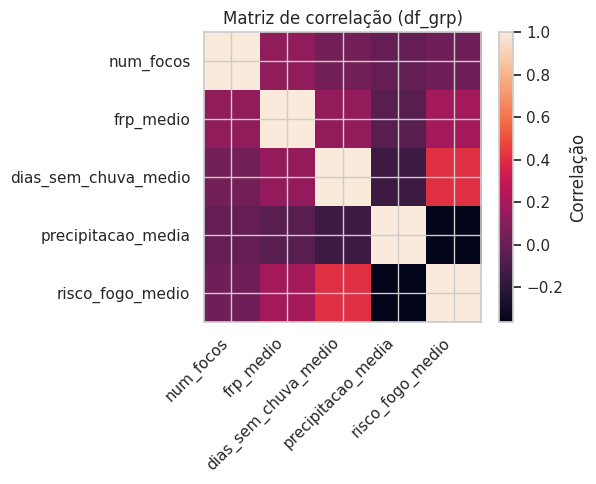

In [17]:
corr = df_grp[["num_focos", "frp_medio", 
               "dias_sem_chuva_medio", 
               "precipitacao_media", 
               "risco_fogo_medio"]].corr()

print(corr.round(2))

plt.figure(figsize=(6,5))
plt.imshow(corr, aspect="auto")
plt.xticks(range(len(corr.columns)), corr.columns, rotation=45, ha="right")
plt.yticks(range(len(corr.index)), corr.index)
plt.colorbar(label="Correlação")
plt.title("Matriz de correlação (df_grp)")
plt.tight_layout()
plt.show()


# Clusterização

In [18]:
# Só os atributos numéricos que vão entrar no clustering
feature_cols = [
    "num_focos",
    "frp_medio",
    "dias_sem_chuva_medio",
    "precipitacao_media",
    "risco_fogo_medio"
]

X = df_grp[feature_cols].fillna(0)

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)


In [11]:
sil_scores = {}

for k in range(2, 10):
    kmeans = KMeans(n_clusters=k, random_state=42)
    labels = kmeans.fit_predict(X_scaled)
    sil = silhouette_score(X_scaled, labels)
    sil_scores[k] = sil

sil_scores

# 6 cluters é o melhor, não precisa rodar denovo


{2: 0.3693424057223254,
 3: 0.37694479906888084,
 4: 0.4158311778474713,
 5: 0.42957190160644376,
 6: 0.45281463191943566,
 7: 0.39550175311123786,
 8: 0.40615734812805043,
 9: 0.41537713982588925}

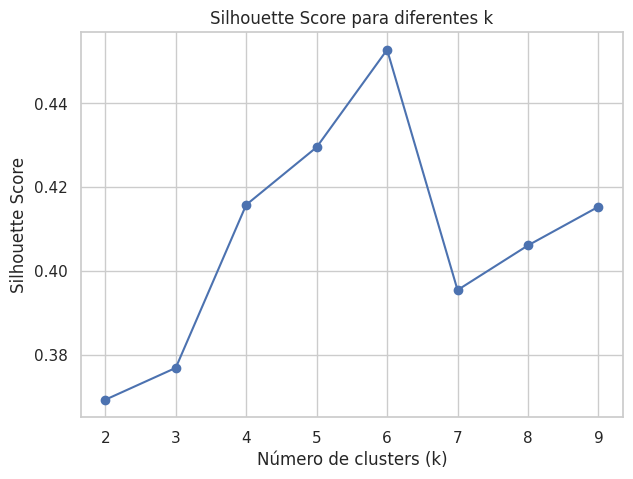

In [12]:
# Plotar silhouette x k
plt.figure(figsize=(7,5))
plt.plot(list(sil_scores.keys()), list(sil_scores.values()), marker="o")
plt.title("Silhouette Score para diferentes k")
plt.xlabel("Número de clusters (k)")
plt.ylabel("Silhouette Score")
plt.show()


In [19]:
k_final = 6

kmeans = KMeans(n_clusters=k_final, random_state=42)
labels_kmeans = kmeans.fit_predict(X_scaled)

df_grp["cluster_kmeans"] = labels_kmeans

df_grp.head()


,Estado,Municipio,Bioma,ano,mes,num_focos,frp_medio,dias_sem_chuva_medio,precipitacao_media,risco_fogo_medio,cluster_kmeans
0,ACRE,ACRELANDIA,AMAZONIA,2016,6,4,23.900000,10.500000,0.000000,0.925000,1
1,ACRE,ACRELANDIA,AMAZONIA,2016,7,24,53.762500,19.208333,0.000000,1.000000,1
2,ACRE,ACRELANDIA,AMAZONIA,2016,8,66,76.672727,9.030303,0.445455,0.784848,1
3,ACRE,ACRELANDIA,AMAZONIA,2016,9,90,63.167778,4.177778,0.326667,0.666667,1
4,ACRE,ACRELANDIA,AMAZONIA,2016,10,4,17.125000,0.750000,3.050000,0.850000,1


In [20]:
df_grp.groupby("cluster_kmeans")[feature_cols].mean().round(2)


,num_focos,frp_medio,dias_sem_chuva_medio,precipitacao_media,risco_fogo_medio
cluster_kmeans,,,,,
0,7.70,21.64,3.34,1.17,0.20
1,8.81,30.07,10.86,0.20,0.91
2,23.38,190.43,20.45,0.29,0.89
3,3.24,21.57,2.64,16.08,0.07
4,1001.96,82.82,16.88,0.72,0.73
5,14.56,40.99,75.66,0.07,0.99


## PCA

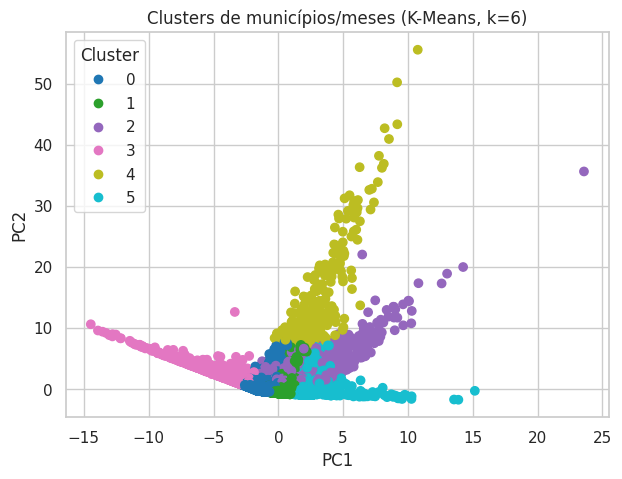

In [21]:
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

plt.figure(figsize=(7,5))
scatter = plt.scatter(X_pca[:,0], X_pca[:,1],
                      c=df_grp["cluster_kmeans"], cmap="tab10")
plt.title(f"Clusters de municípios/meses (K-Means, k={k_final})")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.legend(*scatter.legend_elements(), title="Cluster")
plt.show()


## Tamanho dos Clusters

cluster_kmeans
0    57953
1    90618
2     5564
3     3892
4      286
5    18371
Name: count, dtype: int64


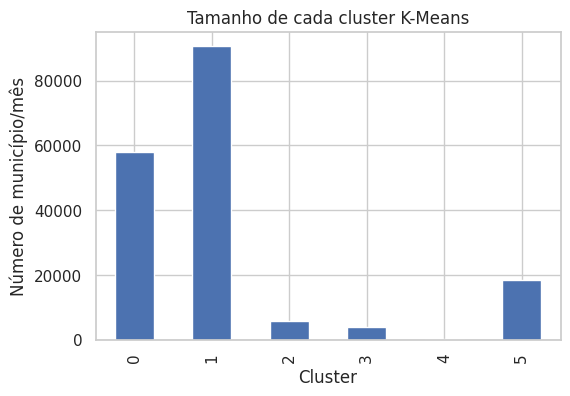

In [22]:
cluster_sizes = df_grp["cluster_kmeans"].value_counts().sort_index()
print(cluster_sizes)

plt.figure(figsize=(6,4))
cluster_sizes.plot(kind="bar")
plt.title("Tamanho de cada cluster K-Means")
plt.xlabel("Cluster")
plt.ylabel("Número de município/mês")
plt.show()


## Distribuição dos Clusters por Bioma e por Estado

cluster_kmeans      0      1     2     3     4      5
Bioma                                                
AMAZONIA        52.85  37.42  2.20  3.75  0.67   3.11
CAATINGA        10.88  61.66  3.53  0.91  0.00  23.03
CERRADO         28.08  51.23  4.36  2.72  0.03  13.58
MATA ATLANTICA  35.01  55.94  2.32  1.41  0.00   5.32
PAMPA           65.03  33.33  0.83  0.71  0.00   0.09
PANTANAL        38.06  47.56  4.98  2.35  3.67   3.38


<Figure size 1000x600 with 0 Axes>

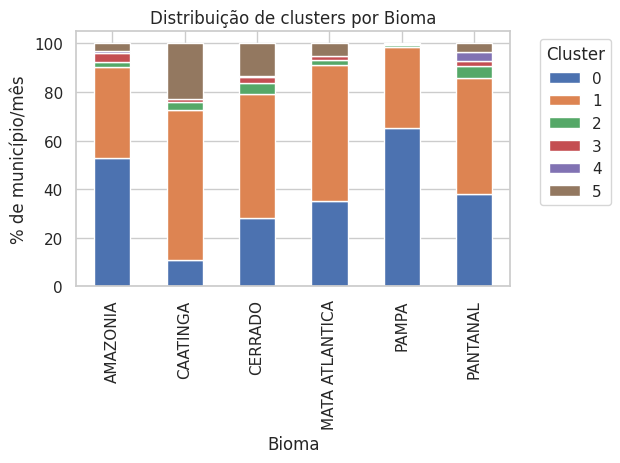

In [23]:
# Distribuição de clusters por Bioma
bioma_cluster = pd.crosstab(df_grp["Bioma"], df_grp["cluster_kmeans"], normalize="index") * 100
print(bioma_cluster.round(2))

plt.figure(figsize=(10,6))
bioma_cluster.plot(kind="bar", stacked=True)
plt.ylabel("% de município/mês")
plt.title("Distribuição de clusters por Bioma")
plt.legend(title="Cluster", bbox_to_anchor=(1.05, 1), loc="upper left")
plt.tight_layout()
plt.show()


In [24]:
# Distribuição de clusters por Estado
estado_cluster = pd.crosstab(df_grp["Estado"], df_grp["cluster_kmeans"], normalize="index") * 100
print(estado_cluster.round(2))


cluster_kmeans           0      1     2     3     4      5
Estado                                                    
ACRE                 59.49  35.94  0.22  2.54  1.59   0.22
ALAGOAS               7.32  75.78  2.49  0.72  0.00  13.68
AMAPA                43.34  54.35  0.14  2.17  0.00   0.00
AMAZONAS             85.59   7.59  0.95  4.28  1.56   0.02
BAHIA                14.58  63.91  3.60  0.94  0.01  16.96
CEARA                 8.48  58.49  2.89  0.44  0.00  29.71
DISTRITO FEDERAL     16.47  60.00  0.00  4.71  0.00  18.82
ESPIRITO SANTO       17.01  72.34  0.94  1.27  0.00   8.45
GOIAS                24.69  50.15  4.74  3.00  0.00  17.42
MARANHAO             30.81  57.78  2.51  2.11  0.03   6.76
MATO GROSSO          46.45  34.39  4.54  4.80  0.30   9.51
MATO GROSSO DO SUL   37.07  53.79  4.20  3.18  0.50   1.27
MINAS GERAIS         15.91  64.86  2.85  1.44  0.00  14.95
PARA                 57.07  36.11  1.06  3.69  0.86   1.22
PARAIBA               9.63  62.25  3.40  0.69  0.00  24.

## Séries Temporais

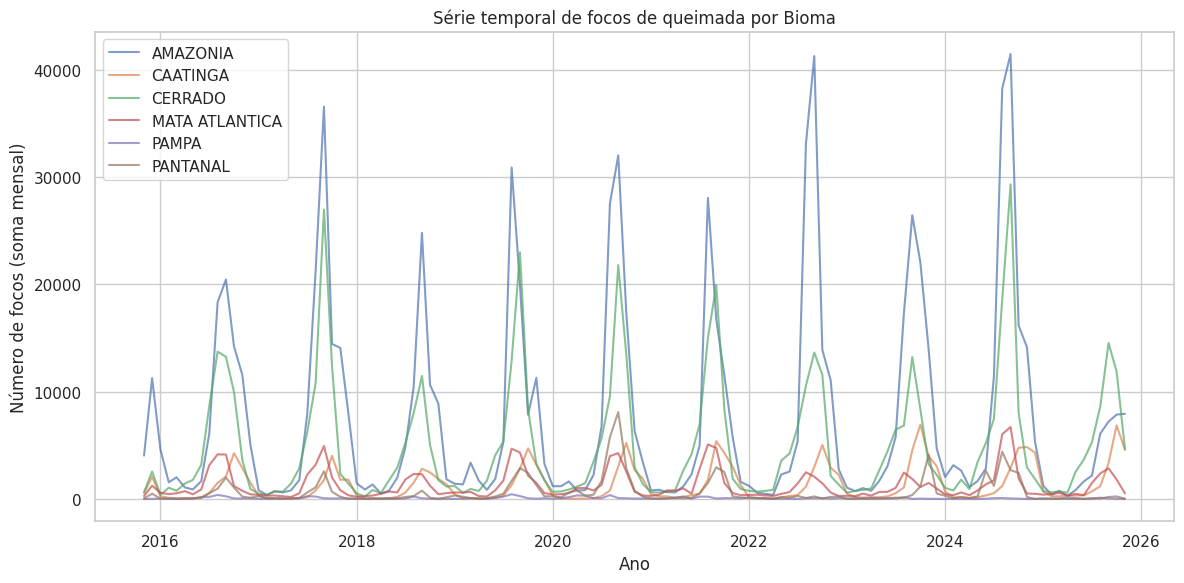

In [25]:
# Agrega por ano, mes, bioma
ts_bioma = (df_grp
            .groupby(["ano", "mes", "Bioma"], as_index=False)["num_focos"]
            .sum())

# Cria uma coluna de data (1º dia de cada mês)
ts_bioma["data"] = pd.to_datetime(dict(year=ts_bioma["ano"],
                                       month=ts_bioma["mes"],
                                       day=1))

plt.figure(figsize=(12,6))
for bioma, sub in ts_bioma.groupby("Bioma"):
    sub = sub.sort_values("data")
    plt.plot(sub["data"], sub["num_focos"], label=bioma, alpha=0.7)

plt.title("Série temporal de focos de queimada por Bioma")
plt.xlabel("Ano")
plt.ylabel("Número de focos (soma mensal)")
plt.legend()
plt.tight_layout()
plt.show()


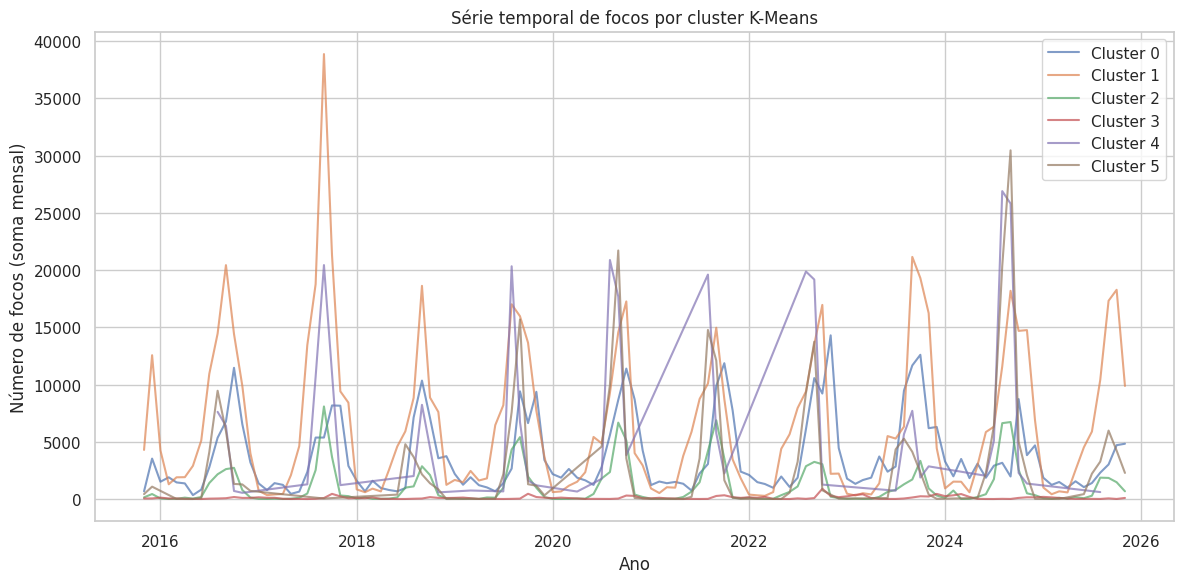

In [26]:
ts_cluster = (df_grp
              .groupby(["ano", "mes", "cluster_kmeans"], as_index=False)["num_focos"]
              .sum())
ts_cluster["data"] = pd.to_datetime(dict(year=ts_cluster["ano"],
                                         month=ts_cluster["mes"],
                                         day=1))

plt.figure(figsize=(12,6))
for k, sub in ts_cluster.groupby("cluster_kmeans"):
    sub = sub.sort_values("data")
    plt.plot(sub["data"], sub["num_focos"], label=f"Cluster {k}", alpha=0.7)

plt.title("Série temporal de focos por cluster K-Means")
plt.xlabel("Ano")
plt.ylabel("Número de focos (soma mensal)")
plt.legend()
plt.tight_layout()
plt.show()


# LLM

In [27]:
def buscar_historico(df_grp, estado, municipio, bioma, mes, n_anos=5):
    mask = (
        (df_grp["Estado"] == estado) &
        (df_grp["Municipio"] == municipio) &
        (df_grp["Bioma"] == bioma) &
        (df_grp["mes"] == mes)
    )
    hist = (df_grp.loc[mask]
                   .sort_values("ano", ascending=False)
                   .head(n_anos))
    return hist


In [28]:
# Exemplo: ajuste conforme sua interpretação
clusters_baixa = [3, 0]
clusters_media = [1]
clusters_alta  = [5, 2]
clusters_extrema = [4]

def resumo_severidade(df):
    if df.empty:
        return None

    cont = df["cluster_kmeans"].value_counts()
    total = cont.sum()

    def pct_clusters(lista):
        return cont[cont.index.isin(lista)].sum() / total * 100

    resumo = {
        "p_baixa": pct_clusters(clusters_baixa),
        "p_media": pct_clusters(clusters_media),
        "p_alta": pct_clusters(clusters_alta),
        "p_extrema": pct_clusters(clusters_extrema),
        "anos_disponiveis": sorted(df["ano"].unique().tolist(), reverse=True),
    }
    return resumo


In [29]:
feature_cols_sim = [
    "num_focos",
    "frp_medio",
    "dias_sem_chuva_medio",
    "precipitacao_media",
    "risco_fogo_medio"
]

def preparar_base_similaridade(df_grp):
    # IMPORTANTE: resetar o índice aqui!
    df_sim = df_grp.dropna(subset=feature_cols_sim).copy()
    df_sim = df_sim.reset_index(drop=True)

    X = df_sim[feature_cols_sim].values
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    return df_sim, X_scaled, scaler

df_sim, X_sim_scaled, scaler_sim = preparar_base_similaridade(df_grp)


In [30]:
# Não ta legal pra usar

def buscar_similares(df_sim, X_sim_scaled, scaler_sim,
                     bioma, mes, k=5):
    # Filtra por mesmo bioma e mês
    mask = (
        (df_sim["Bioma"] == bioma) &
        (df_sim["mes"] == mes)
    )
    candidatos = df_sim[mask]

    if candidatos.empty:
        # fallback: ignora mês, usa só bioma
        candidatos = df_sim[df_sim["Bioma"] == bioma]

    if candidatos.empty:
        # fallback final: usa tudo
        candidatos = df_sim

    # Índices POSICIONAIS na matriz X_sim_scaled
    idx_candidatos = candidatos.index.to_numpy()
    X_cand = X_sim_scaled[idx_candidatos]

    # Aqui ainda estou usando a média dos candidatos como query genérica
    x_query = X_cand.mean(axis=0, keepdims=True)

    from sklearn.metrics.pairwise import cosine_similarity
    sims = cosine_similarity(x_query, X_cand)[0]
    idx_ord = np.argsort(-sims)[:k]

    similares = candidatos.iloc[idx_ord].copy()
    similares["similaridade"] = sims[idx_ord]

    return similares


In [31]:
def checar_303030(temperatura, umidade, vento):
    cond_temp = temperatura >= 30
    cond_umid = umidade <= 30
    cond_vento = vento >= 30

    flag = cond_temp and cond_umid and cond_vento
    return {
        "flag_303030": flag,
        "cond_temp": cond_temp,
        "cond_umid": cond_umid,
        "cond_vento": cond_vento
    }


In [32]:
def avaliar_perigo_fogo(df_grp,
                        df_sim, X_sim_scaled, scaler_sim,
                        estado, municipio, bioma, mes,
                        temperatura, umidade, vento):
    
    estado = normalizar_texto(estado)
    municipio = normalizar_texto(municipio)
    bioma = normalizar_texto(bioma)

    # 1) Busca histórico exato
    hist = buscar_historico(df_grp, estado, municipio, bioma, mes)

    if not hist.empty:
        modo = "historico"
        resumo_hist = resumo_severidade(hist)
        resumo_sim = None
    else:
        modo = "similares"
        resumo_hist = None
        #similares = buscar_similares(df_sim, X_sim_scaled, scaler_sim,
        #                             bioma=bioma, mes=mes, k=5)
        #resumo_sim = resumo_severidade(similares)
        resumo_sim = None

    # 2) Regra 30–30–30
    info_30 = checar_303030(temperatura, umidade, vento)

    # 3) Pacote de saída (que você pode jogar pra LLM ou usar pra gerar texto)
    resultado = {
        "modo": modo,
        "resumo_historico": resumo_hist,
        #"resumo_similares": resumo_sim,
        "info_303030": info_30,
        "inputs_usuario": {
            "estado": estado,
            "municipio": municipio,
            "bioma": bioma,
            "mes": mes,
            "temperatura": temperatura,
            "umidade": umidade,
            "vento": vento
        }
    }

    return resultado


In [33]:
res = avaliar_perigo_fogo(
    df_grp,
    df_sim, X_sim_scaled, scaler_sim,
    estado="MINAS GERAIS",
    municipio="HORIZONTE",
    bioma="CERRADO",
    mes=8,
    temperatura=34,
    umidade=25,
    vento=35
)

print(res)


{'modo': 'similares', 'resumo_historico': None, 'info_303030': {'flag_303030': True, 'cond_temp': True, 'cond_umid': True, 'cond_vento': True}, 'inputs_usuario': {'estado': 'MINAS GERAIS', 'municipio': 'HORIZONTE', 'bioma': 'CERRADO', 'mes': 8, 'temperatura': 34, 'umidade': 25, 'vento': 35}}


# LLM + RAG simples

In [34]:
import os
import time
import openai

In [ ]:


# 1. Instala o Ollama (só precisa na primeira vez da sessão)
print("Instalando o Ollama...")
os.system("curl -fsSL https://ollama.com/install.sh | sh")
print("Instalação do Ollama concluída.")

# 2. Inicia o servidor Ollama em background
os.system("nohup ollama serve &")
print("Iniciando o servidor Ollama... (aguardando 10 segundos para inicialização)")
time.sleep(10)

# 3. Baixa o modelo (se ainda não estiver presente)
print("\nBaixando o modelo llama3.1...")
os.system("ollama pull llama3.1")
print("Modelo pronto para uso.")


Instalando o Ollama...


>>> Installing ollama to /usr/local


Instalação do Ollama concluída.
Iniciando o servidor Ollama... (aguardando 10 segundos para inicialização)


nohup: failed to run command 'ollama': No such file or directory



Baixando o modelo llama3.1...
Modelo pronto para uso.

Configuração concluída. O ambiente está pronto para usar o LLM.


sh: 1: ollama: not found


In [35]:
from openai import OpenAI

client = OpenAI(
    base_url="http://localhost:11434/v1",  # endpoint do Ollama
    api_key="ollama",                      # qualquer string funciona
)

In [38]:
def montar_prompt_para_llm(res):
    inp = res["inputs_usuario"]
    info30 = res["info_303030"]
    
    if res["modo"] == "historico":
        origem = "Histórico do próprio município (últimos anos)."
        resumo = res["resumo_historico"]
    else:
        origem = "Eventos históricos mais similares (outros municípios)."
        resumo = res["resumo_similares"]

    if resumo is None:
        resumo_txt = "Não foi possível calcular estatísticas de severidade."
    else:
        resumo_txt = (
            f"- Severidade baixa: {resumo['p_baixa']:.1f}%\n"
            f"- Severidade média: {resumo['p_media']:.1f}%\n"
            f"- Severidade alta: {resumo['p_alta']:.1f}%\n"
            f"- Severidade extrema: {resumo['p_extrema']:.1f}%\n"
        )

    texto_30 = (
        f"Temperatura atual: {inp['temperatura']} °C\n"
        f"Umidade relativa: {inp['umidade']} %\n"
        f"Velocidade do vento: {inp['vento']} km/h\n"
        f"Fenômeno 30-30-30 atendido? {info30['flag_303030']}\n"
    )

    prompt = f"""
Você é um assistente especialista em risco de queimadas no Brasil.
Responda em português simples, em no máximo 2 parágrafos.

Local:
- Estado: {inp['estado']}
- Município: {inp['municipio']}
- Bioma: {inp['bioma']}
- Mês: {inp['mes']}

Fonte de informação usada:
{origem}

Histórico de severidade (com base em clusters de queimadas):
{resumo_txt}

Condições atmosféricas do usuário:
{texto_30}

Explique:
1) Qual é a probabilidade aproximada de ocorrer fogo neste contexto (baixa, média, alta).
2) Qual é a severidade esperada caso ocorra fogo (baixa, média, alta, extrema).
3) Justifique usando o histórico/semelhantes e o fenômeno 30-30-30.
4) Dê 2 recomendações práticas de prevenção para a população local.
"""
    return prompt.strip()


In [39]:
res = avaliar_perigo_fogo(
    df_grp,
    df_sim, X_sim_scaled, scaler_sim,
    estado="Mato Grosso",
    municipio="Sinop",
    bioma="Amazônia",
    mes=8,
    temperatura=34,
    umidade=25,
    vento=35
)

prompt = montar_prompt_para_llm(res)

resp = client.chat.completions.create(
    model="llama3.1",
    messages=[
        {"role": "system", "content": "Você é um assistente que responde em português de forma clara e responsável."},
        {"role": "user", "content": prompt},
    ],
    max_tokens=400,
)

print(resp.choices[0].message.content)


**Probabilidade aproximada de ocorrer fogo:** Alta
**Severidade esperada caso ocorra fogo:** Alta

Com base no histórico do município e nas condições atmosféricas atuais, há grande probabilidade de ocorrerem incêndios florestais em Sinop, MATO GROSSO. A temperatura atual é elevada (34 °C), a umidade relativa está muito baixa (25 %) e o vento é forte (35 km/h). Além disso, com 80% de severidade alta nos clusters de queimadas nos últimos anos, isso reforça a expectativa. Este cenário atende às condições do Fenômeno 30-30-30 e os indicativos históricos aumentam o risco.

2 recomendações práticas para a população local: 
1) Evitar tocar fogo em qualquer lugar, especialmente nos períodos mais quentes do dia. A precaução é fundamental nesta época.
2) Proteger áreas como jardins ou gramas de ervas, cortando o crescimento alto da vegetação para reduzir a probabilidade de surgirem incêndios e melhorar controle em caso de fogo espontâneo.
